# 5 Modeling<a id='5_Modeling'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Load Data](#5.4_Load_Data)
  * [5.5 Load Model](#5.5_Load_Model)
  * [5.6 Refit on all data](#5.6_Refit_on_all_data)
  * [5.7 Predict](#5.7_Predict)
  * [5.8 Summary](#5.8_Summary)

## 5.2 Introduction<a id='5.2_Introduction'></a>

In this notebook, I am going to use the random forest model from the last notebook to make predictions on the holdout data set. 

## 5.3 Imports<a id='5.3_Imports'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier

## 5.4 Load Data<a id='5.4_Load_Data'></a>

In [2]:
X = pd.read_csv('../data/features.csv', index_col = 'id')
y = pd.read_csv('../data/labels.csv')
y.drop('id', axis=1, inplace=True)

In [3]:
X_holdout = pd.read_csv('../data/holdout_data/X_hold.csv', index_col = 'id')
y_holdout = pd.read_csv('../data/holdout_data/y_hold.csv')
y_holdout.drop('id', axis=1, inplace=True)

In [4]:
y = y.to_numpy().ravel().astype(int)
y_holdout = y_holdout.to_numpy().ravel().astype(int)

In [5]:
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=21)
X = rfe.fit_transform(X, y)

In [7]:
X_test = rfe.transform(X_holdout)

## 5.5 Load Model<a id='5.5_Load_Model'></a>

best_params = {'bootstrap': True, 'max_depth': 40, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}

In [8]:
rf = RandomForestClassifier(bootstrap=True, max_depth=40, max_features='auto', min_samples_split=2, n_estimators=200)

## 5.6 Refit on all data<a id='5.6_Refit_on_all_data'></a>

Here I am going to refit my random forest model, from the Preprocessing and Training Notebook, on all available training data X and y.

In [9]:
rf.fit(X,y)

RandomForestClassifier(max_depth=40, n_estimators=200)

## 5.7 Predict<a id='5.7_Predict'></a> 

In [10]:
predict_y = rf.predict(X_test)

In [11]:
# adapted from https://gist.github.com/rajaraghav/43dc6ee38d8db48dfa47b3505d0b8a2b
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [12]:
print_score(y_holdout, predict_y, train=False)

Test Result:
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.951434      0.112907  0.941863       0.532170       0.910093
recall          0.989350      0.026138  0.941863       0.507744       0.941863
f1-score        0.970022      0.042449  0.941863       0.506235       0.924291
support    711200.000000  36881.000000  0.941863  748081.000000  748081.000000
_______________________________________________
Confusion Matrix: 
 [[703626   7574]
 [ 35917    964]]



In [16]:
36881/711200

0.051857424071991

In [18]:
964/36881

0.026138119899135056

In [13]:
roc_auc_score(y_holdout, predict_y)

0.5077442567999613

In [14]:
from sklearn.metrics import precision_recall_curve, auc
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# predict probabilities
rf_probs = rf.predict_proba(X_test)
# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]

# calculate precision and recall for each threshold
rf_precision, rf_recall, _ = precision_recall_curve(y_holdout, rf_probs)
# calculate scores
rf_f1, rf_auc = f1_score(y_holdout, predict_y), auc(rf_recall, rf_precision)
# summarize scores
print('Model: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))

Model: f1=0.042 auc=0.080


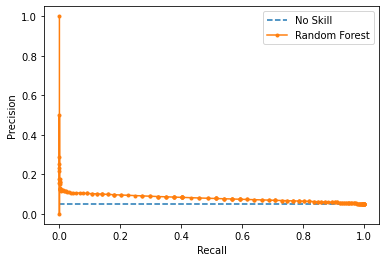

In [17]:
# plot the precision-recall curves
no_skill = len(y_holdout[y_holdout==1]) / len(y_holdout)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(rf_recall, rf_precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

## 5.8 Summary<a id='5.8_Summary'></a>

The model is predicting 94% of the loans in the holdout set correctly but it is only correctly predicting less than 3% of the defaulted loans.